# Anomaly detection from raw images (all objects) - training

This Notebook serves a purpose to identify anomalies based on the patterns encoded in the raw images.

These anomalies can be turned into potential security alerts for home owners, or they can simply become a slideshow from the most interesting events during the day (to avoid having to scan through all the images in search for key/unusual events).

The current state of affairs in terms of using DL for anomaly detection is described well in [this paper](https://arxiv.org/abs/1901.03407)

#### TODO: Add a summary from the paper above

### General idea

We can use an unsupervised ML to train a model to learn predicting the data from the images.

Model will learn to reconstruct the most common images (not-anomalous), but when it comes aross an anomaly, it will reconstruct it with a high error. When this error is higher than some threshold, then we classify this image as anomalous.

These type of models are called the Auto Encoders. They have some other use cases as well, like data compression or noise removal, but I will utilise a Convolution-based auto encoder to detect anomaly in our dataset with raw images.

#### TODO: provide theory about how autoencoders work
[paper is here](https://arxiv.org/pdf/1606.08921.pdf)

### Training strategy:
- load raw images from the disk
- preprocess images
- reshape/normalize data
- split dataset into train and test sets
- define autoencoder architecture
- train autoencoder and analyse training results
- use test set and see which results produced the highest error
- find an error threshold based on the percentage of anomalies we want to find (for example 0.7%)

### Challenges / experiments to perform:
Here are the main questions, which I will try to answer in my analysis:
- should we split the datsets by class or perform one training for all classes and let algorithm find anomalies?
- how many images do we need to be representative? (whole dataset is almost 650K samples)?
- what resolution should the images be resized to?
- should image pre-processing techniques be applied (thresholding for example)?
- what is the impact of including only a region of interest (ROI), for example masking the terrain outside of the parking slot?
- can Variational Auto Encoder (more sophisticated version of Auto Encoder with regulated distribution of latent space) do a better job at detecting outliers?

In [2]:
# import ConfigImports Notebook to import and configure libs
%run ../ConfigImports.ipynb

TF -> Using GPU ->  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Load dataset and clean it up

First, lets load a dataframe with all image dates and filenames from a previously stored parquet file.

Then lets remove the outage dates.

In [3]:
df = pd.read_parquet('../Datasets/AllObjectDetections_2019-09-09_2020-03-02.parquet.gzip')
df = df.drop(labels=['index'], axis=1)
df.head(2)

,img_idx,label,confidence,x1,y1,x2,y2,date,time,filename,img_n_boxes,time_ms,date_time,week_day,is_weekend,month,hour,min
0,72846,car,0.523175,298,7,426,71,2019-09-09,07.02.40,07.02.40.270_34c99836_car-car-car.jpg,1,270,2019-09-09 07:02:40.270,Monday,False,9,7,2
1,72847,person,0.759682,489,31,518,106,2019-09-09,12.02.42,12.02.42.921_ea6c9143_person-bicycle.jpg,2,921,2019-09-09 12:02:42.921,Monday,False,9,12,2


In [4]:
idx = df['date'].isin(CONFIG['DOWNTIME_DATES'])
df = df.loc[~idx]
df.shape

(643471, 18)

### Computer Vision

We need to use some Computer Vision in order to view and process images.

First, we need a quick way of displaying images in the Notebook. This is handled by the `imshow` function below, which is flexible enough to handle 3 types of inputs to display an image:
- image file path
- image as numpy array
- grayscale and color images

Next, I have defined the `process_frame` function, which allows to perform following operations on an image using flags as function arguments. It was partly inspired by a [PyImageSearch Blog-post](https://www.pyimagesearch.com/2017/07/10/using-tesseract-ocr-python/)
- convert to gray scale 
- apply Median blur
- apply Thresholding
- crop ROI using polyfill

#### TODO: Provide theory for pre-processing steps above (especially thresholding using OTSU method)

In [5]:
def imshow(img, width=12, height=6):
    """
    Show image using matplotlib. Function takes a path or a 
    numpy image and renders it in RBG color-space
    """
    if isinstance(img, str):
        img = cv2.imread(img)
    rcParams['figure.figsize'] = width, height
    plt.axis('off')
    print(img.shape)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));
    plt.show()

def process_frame(frame, dims, is_gray=True, is_blur=False, is_thresh=False, is_polyfill=False,
                  poly_values=None, debug_poly=False):
    """
    Preprocess frame for Machine Learning:    
    - resize to desired size to improve performance and reduce noise
    - change to gray scale to improve performance and remove color variances
    - apply Gaussian blur to remove noise
    - threshold to partition an image into foreground and background
    - mask out an area of an image bases on a poly shape
    """
    if frame is None or frame.shape[0] == 0:
        raise ValueError('Error: issue with frame!')
    frame = cv2.resize(frame, dims)
    if is_gray:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    if is_blur:
        frame = cv2.medianBlur(frame, 3)
        # frame = cv2.GaussianBlur(frame, (11, 11), 0)
        #frame = cv2.erode(frame, None, iterations=1)
        #frame = cv2.dilate(frame, None, iterations=2)
    if is_thresh:
        frame = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    if is_polyfill:
        wh  = np.array([frame.shape[0], frame.shape[1]])
        poly_shape = np.array([poly_values * wh]).astype(np.int32)
        cv2.fillConvexPoly(frame, poly_shape, (0, 0, 0))
        if debug_poly:
            for points in poly_shape:
                for i, p in enumerate(points):
                    text_points = (p[0] + 2 if p[0] < wh[0] else p[0] - 18, p[1] + 24)
                    frame = cv2.circle(frame, tuple(p), 3, (0,255,0), 3)
                    cv2.putText(frame, str(i), text_points, cv2.FONT_HERSHEY_SIMPLEX, 
                            0.7, (0,0,255), 2)
    return frame

### Image processing examples

Below are a few examples of how an image will look  when various image processing techniques are applied. Let's take a look at the original image we will be testing first:

(720, 1280, 3)


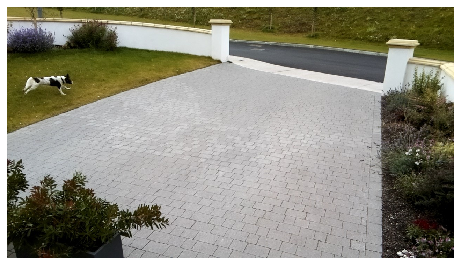

In [6]:
im_path = '../Datasets/anomalies_labelled/yes/11.49.52.975_06f3ace1_dog.jpg'
# im_path = '/data/security_cam_detections_v2/Front-Parking/2019-12-16/08.39.24.685_1a00446f_car.jpg'
im_raw = cv2.imread(im_path)
imshow(im_raw, 8)

And now we can see the same image processed in 3 different ways:
- blurred
- thresholded
- polyfilled

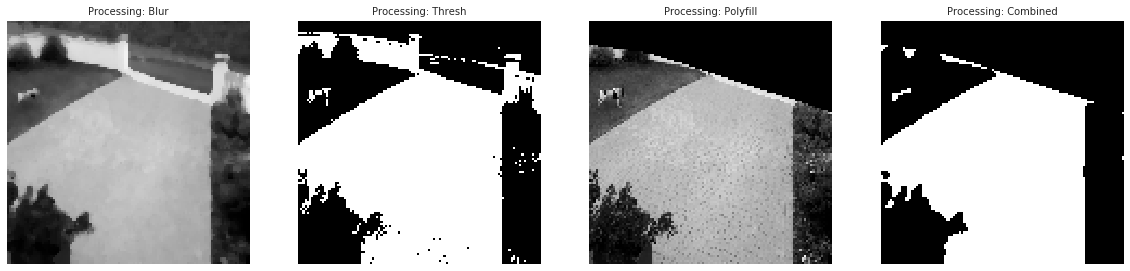

In [7]:
WIDTH, HEIGHT = 112, 112
POLY_VALUES = np.array([[0, 0], [1, 0], [1, 0.37], [0.5, 0.21], [0.25, 0.13], [0, 0.09]])  # poly-shape to mask
params = (
    ('Blur', True, False, False),
    ('Thresh', False, True, False),
    ('Polyfill', False, False, True),
    ('Combined', True, True, True)
)
fig = plt.figure(figsize=(20,10)) # specifying the overall grid size

for i, p in enumerate(params):
    plt.subplot(1, 4, i+1)    # the number of images in the grid is 1*4
    img = process_frame(im_raw.copy(), (WIDTH, HEIGHT), is_gray=True, is_blur=p[1],
                        is_thresh=p[2], is_polyfill=p[3], poly_values=POLY_VALUES)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Processing: {p[0]}', fontdict={'fontsize': 10})
    plt.axis('off')
plt.show()

The 3 images displayed above are for the demonstration purposes only, as in the actual search for optimal parameters below, all the parameters are mixed with each other to create a carthesian product of all possible parameters.

On top of that we also have an image size, which I will experiment with too.

### Unsupervised Learning with Auto Encoders / Data Preparation

Before we can train the auto-encoder, we must first have the data.

Currently we only have a dataframe with the list of all images stored on the disk, but we actually need the raw data behind the images.

The procedure of extracting the raw image data is described in the following steps:
- pre-allocate memory in 2 numpy arrays: one for the image data and one for corresponding filenames
- iterate through the dataframe records (it is assumed that it is a sample from the full dataset) and for each record:
    - open an image from the disk
    - process image using `process_frame` function by using provided pre-processing parameters
        - here we also need to handle the case when image is not readable (missing or corrupted)
    - append image and corresponding filename to the numpy arrays

#### Image size - extra caution!

We need to be extra careful about the resolution of the images. The higher resolution we will use, the more detail will be available to the Deep Learning model, but it comes at a cost.

Single gray-scale 28x28 pixel image will generate a record with 784 features and an image with the size 112x112 will result in 12544 features respectively.

Since the original images' shape is (720, 1280, 3), if we wanted to use the original images it would result in 2,764,800 features only for a single image!

Based on my experiments increasing size to more than 608x608px tends to cause issues with the GPU and it actually degrades the performance of the model, as it learns too much detail (which is often a noise, like leaves, shadows, objects moved by wind etc.)

Another issue with the high image quality is the speed of image pre-processing and model training, and it is a difference between 2 minutes and 35 minutes on a single model training.

For all the above reasons I will only consider image sizes 28x28 and 56x56 in the rest of this Notebook.

Nowe we can define a function called `process_img_batch`, which will prepare our images for the AutoEncoder step, which will be described later.

In [8]:
def process_img_batch(samples, im_width, im_height, is_blur, is_thresh, is_poly, poly_values=None):
    """
    Pre-process multiple images in the sample and return images
    and corresponding filenames as a tuple.
    If an image does not exist on the disk or if it can not be opened,
    a previous image will be appended to the results.
    Parameters
    ----------
    samples : pd.DataFrame
        DataFrame containing date and filename features
    im_width : int
        Width of image to resize to
    im_height : int
        Height of image to resize to
    is_blur : bool
        Should image be blured
    is_thresh : bool
        Should image be thresholded
    is_poly : bool
        Should image be masked
    poly_values : np.array
        Polygon (convex) shape to mask in the image
    Returns
    -------
    tuple
       List of images in numpy arrays and list of
       corresponding filenames -> (np.array, np.array)
    """
    
    # pre-allocate memory for the image data
    im_data = np.zeros((samples.shape[0], im_width, im_height), dtype='uint8')
    im_filepaths = []

    # iterate through images and store in previously defined numpy array
    im_processed_prev = None
    im_path_prev = None
    for i, (im_date, im_filename) in tqdm(enumerate(samples[['date', 'filename']].to_numpy())):
        im_path = f'{CONFIG["IMG_BASE_DIR"]}/{im_date}/{im_filename}'
        im_raw = cv2.imread(im_path)
        try:
            im_processed = process_frame(im_raw, (im_width, im_height), is_gray=True, is_blur=is_blur,
                                         is_thresh=is_thresh, is_polyfill=is_poly, poly_values=poly_values)
        except Exception as e:
            # if exception occurs when reading image, use previous image again
            print('Exception, will use previous image instead.', str(e), im_path)
            im_data[i] = im_processed_prev
            im_filepaths.append(im_path_prev)
            continue
        im_processed_prev = im_processed.copy()
        im_path_prev = im_path
        im_data[i] = im_processed
        im_filepaths.append(im_path)
    im_filepaths = np.array(im_filepaths)
    
    return im_data, im_filepaths

Now we can prepare a sample dataset by sampling a 10,000 records from the dataframe `df` with the image filenames.

In the preprocessing step I am passing the `POLY_VALUES` numpy array to mask the region, which we don't want the model to observe for changes (for example if we are not interested in anomalies on the street or footpath).

During my experiments I found that 28x28 or 56x56 resolutions are sufficient to achieve good results, and they are faster to execute than larger image dimensions and require less compute power.

For the remainder of the experiment, I will be using 25K images with 56x56 resolution.

In [130]:
# sample records from the dataframe
NUM_ROWS = 25000
samples = df.sample(NUM_ROWS, random_state=CONFIG['RANDOM_STATE'])  # provide random_state for reproducibility

# pre-process images into a numpy array
WIDTH, HEIGHT = 56, 56
# POLY_VALUES = np.array([[0, 0], [1, 0], [1, 0.37], [0.5, 0.21], [0.25, 0.13], [0, 0.09]])
# im_data, im_filepaths = process_img_batch(samples, WIDTH, HEIGHT, True, True, True, POLY_VALUES)

# load datasets from disk
# real_params = ((25000, 50000), (28, 56, 112), (False, True), (False, True), (False, True))
model_name = f'nsamples{NUM_ROWS}_res{WIDTH}_blurTrue_threshTrue_polyTrue'
im_data = np.load(f'../Datasets/raw_images_processed/img__{model_name}.npy')
im_filepaths = np.load(f'../Datasets/raw_images_processed/filepaths__{model_name}.npy')

How long does it take to preprocess the images?

I turned out that the main factor infuencing the speed is just the number of images to use (all computer vision operations are very fast).

In my experiments (on Intel i5 with NVME M2 Solid State Drive), I've collected the following statistics for the 28x28 images with all computer vision operations enabled:

| Sample Size | Time To Process |
| ----------- | --------------- |
| 1,000       | 10.1 s          |
| 10,000      | 1min 44s        |
| 50,000      | 8min 35s        |

Now we can display more information about the training data.

It's always worth looking into the RAM consumption. In case of 25,000 records, it's around 75MB, and with larger data samples of greater resolutions, this can easily go to a few GB.

Next, we need to add additional dimension to the dataset, as Neural Network will expect the shape of (height, width and depth). The depth is in case if we wanted to use the color images.

Now we can normalize the data on a 0-1 scale. Since image data is a `uint8` type, it can take values only between 0 and 255, so dividing all values by 255.0 is the standard normalisation step for image data. We just need to remember that normalized data becomes a `float32` type:

$$normalize(X)=X/255.0$$

And the last step here is to split the dataset into train and test splits. Unfortunately due to slow training times it is not adviced to run cross validation splits for Deep Neural Networks. I am choosing a 0.8 / 0.2 split with a `random_state` parameter set to 42 for reproducibility reasons.

In [131]:
print(f'Training Data sample shape: {im_data.shape}')
print(f'Size in RAM: {round((im_data.size * im_data.itemsize) / 1024 / 1024, 2)} MB')
print(f"{round(NUM_ROWS / df.shape[0], 3) * 100}% of overall dataset ({NUM_ROWS} out of {df.shape[0]} data points)")

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
im_data = np.squeeze(im_data)
im_data = np.expand_dims(im_data, axis=-1)
im_data = im_data.astype("float32") / 255.0
print(f'Data reshaped shape: {im_data.shape}')

# construct the training and testing split,
# use random_state for reproducability, remove it
# in prodocuction
X_train, X_test, y_train, y_test = train_test_split(im_data, im_filepaths,test_size=0.2,
                                                    random_state=CONFIG['RANDOM_STATE'])
print(f'Train shape: {X_train.shape}, test shape: {X_test.shape}')

Training Data sample shape: (25000, 56, 56)
Size in RAM: 74.77 MB
3.9% of overall dataset (25000 out of 643471 data points)
Data reshaped shape: (25000, 56, 56, 1)
Train shape: (20000, 56, 56, 1), test shape: (5000, 56, 56, 1)


### Unsupervised Learning with Auto Encoders / Training

Now we begin the training process.

Below is an auto-encoder Neural Network architecture definition inspired by another blog entry on [PyImageSearch](https://www.pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/).

#### TODO: Provide more information about design choices below (layers, activation fn, loss fn, optimizer with lr decay etc.)

In [132]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.layers import Activation, Flatten, Dense, Reshape, Input
from tensorflow.keras import backend as K, Model
from tensorflow.keras.optimizers import Adam

def build_ae(im_width, im_height, depth=1, latent_dim=16, cnn_filters=(32, 64), lr=1e-3, epochs=50):
    """
    Build an auto-encoder NN architecture using Keras functional
    API and return a tuple of: auto-encoder, encoder and decoder
    Parameters
    ----------
    im_width : int
        Width of image to resize to
    im_height : int
        Height of image to resize to
    depth : int
        Number of channels in the images
    latent_dim : int
        Number of neurons in the latent (compressed) layer
    cnn_filters : tuple
        Tuple of integers with number of filters to use in Convolutional layers
    lr : float
        Learning rate for the optimizer
    epochs:
        Epochs will be used to calculate the learning rate decay (lr / epochs)
    Returns
    -------
    tuple
       Tuple of Keras models (auto-encoder, encoder and decoder)
    """
    
    # define model params
    input_shape = (im_height, im_width, depth)
    chan_dim = -1

    # define the input to the encoder
    inputs = Input(shape=input_shape)
    x = inputs
    # loop over the number of filters
    for f in cnn_filters:
        # apply a CONV => RELU => BN operation
        x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(axis=chan_dim)(x)
    # flatten the network and then construct our latent vector
    volume_size = K.int_shape(x)
    x = Flatten()(x)
    latent = Dense(latent_dim, name="latent")(x)
    # build the encoder model
    encoder = Model(inputs, latent, name="encoder")

    # start building the decoder model which will accept the
    # output of the encoder as its inputs
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(np.prod(volume_size[1:]))(latent_inputs)
    x = Reshape((volume_size[1], volume_size[2], volume_size[3]))(x)
    # loop over our number of filters again, but this time in
    # reverse order
    for f in cnn_filters[::-1]:
        # apply a CONV_TRANSPOSE => RELU => BN operation
        x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(axis=chan_dim)(x)
    # apply a single CONV_TRANSPOSE layer used to recover the
    # original depth of the image
    x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
    outputs = Activation("sigmoid")(x)
    # build the decoder model
    decoder = Model(latent_inputs, outputs, name="decoder")

    # our autoencoder is the encoder + decoder
    autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")

    # set up an optimised with learning rate decay
    opt = Adam(lr=lr, decay=lr / epochs)
    
    # compile model with mean squared error loss function
    autoencoder.compile(loss="mse", optimizer=opt)
    
    # return all 3 models
    return autoencoder, encoder, decoder

Now we are ready to build the auto-encoder model. We can call the Keras `model.summary` method, which displays a number of trainable parameters.

Given the CNN-based architecture above and 56x56 image size, the model has almost 500K parameters. This number goes up to 1.7M if we choose 112x112 images.

In [133]:
# build coanvolutional auto-encoder, override default epoch size,
# this will be used to set the optimizer's learning rate decay
EPOCHS = 30
ae, enc, dec = build_ae(WIDTH, HEIGHT, epochs=EPOCHS)
ae.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_231 (InputLayer)       [(None, 56, 56, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 16)                219920    
_________________________________________________________________
decoder (Model)              (None, 56, 56, 1)         269313    
Total params: 489,233
Trainable params: 488,849
Non-trainable params: 384
_________________________________________________________________


Now we are ready to actually train the model. For testing purposes lets try with 30 epochs. We will set the `batch_size` parameter to 32 to perform batch Gradient Descent when optimizer updates network parameters.

In [134]:
BS = 32
H = ae.fit(X_train, X_train, validation_data=(X_test, X_test),
           epochs=EPOCHS, batch_size=BS, verbose=1)  # verbose to 1 to display training output

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 6s 282us/sample - loss: 0.0340 - val_loss: 0.0228
Epoch 2/30
20000/20000 [==============================] - 5s 268us/sample - loss: 0.0205 - val_loss: 0.0204
Epoch 3/30
20000/20000 [==============================] - 5s 232us/sample - loss: 0.0182 - val_loss: 0.0180
Epoch 4/30
20000/20000 [==============================] - 5s 226us/sample - loss: 0.0169 - val_loss: 0.0171
Epoch 5/30
20000/20000 [==============================] - 5s 226us/sample - loss: 0.0161 - val_loss: 0.0171
Epoch 6/30
20000/20000 [==============================] - 5s 230us/sample - loss: 0.0153 - val_loss: 0.0158
Epoch 7/30
20000/20000 [==============================] - 5s 237us/sample - loss: 0.0148 - val_loss: 0.0157
Epoch 8/30
20000/20000 [==============================] - 5s 226us/sample - loss: 0.0144 - val_loss: 0.0153
Epoch 9/30
20000/20000 [==============================] - 5s 227us/sample - loss: 0.014

Now training is completed and we can analyse the training convergence using training and validation loss plot.

Let's analyse the convergence plots by defining a `plt_loss` function, which will accept a Keras History object and will plot 2 lines with training and validation losses over epochs.

In [135]:
def plt_loss(H):
    """
    Construct the multi scatter plot to show training and validation loss curves
    Parameters
    ----------
    H : tensorflow.python.keras.callbacks.History
    """
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=H.history['loss'], name='Training Loss', mode='lines'))
    fig.add_trace(go.Scatter(y=H.history['val_loss'], name='Validation Loss', mode='lines'))
    fig.update_layout(title='Training Loss', height=375, width=600, xaxis_title="Epoch", yaxis_title="Loss")
    fig.show()

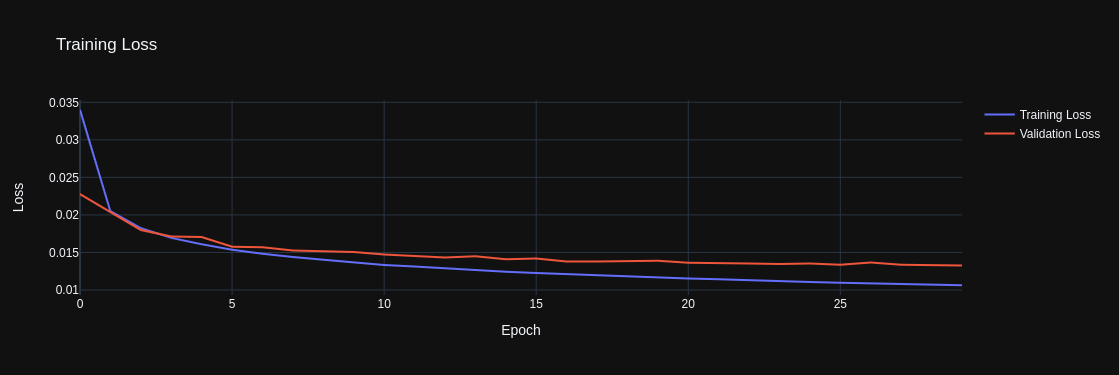

In [136]:
plt_loss(H)

It's clear that the model converges after after around 30 epochs and there is no evidence of overfitting (validation curve stays flat and has slightly higher error than training).


#### Important callout:
It is important that the model still produces some error and does not memorize the whole training set, as this kind of model would not be useful to detect anomalies.

#### How many epochs to choose?
To get an intuition about the relationship of *Sample Size* and *Image Resolution* VS *Seconds per Epoch* and *Epochs to Converge*, I've conducted six experiments with the following results:

| Sample Size | Res.    | Sec. Per Epoch | Epochs to Converge |
|:------------|:-------:|---------------:|-------------------:|
| 25,000      | 28x28   | 3              | 20                 |
| 25,000      | 56x56   | 6              | 30                 |
| 25,000      | 112x112 | 15             | 50                 |
| 50,000      | 28x28   | 5              | 50                 |
| 50,000      | 56x56   | 10             | 50                 |
| 50,000      | 112x112 | 28             | 50                 |

As per intuition, the more samples and higher the resolution, the longer it takes to train each epoch. What is interesting is that for smaller sample size (25,000) and 28x28 resolution, we can get the convergence in only 20 epochs, where for larger sample size, we usually need around 50 epochs to converge.

#### TODO: visualize the latent space

It is interesting to see the latent space, which is responsible for compressing the image data into 16 values (obviously with some information loss).

### Model evaluation on test-set

So the next question is how does this model actually perform on the test-set.

The next step is to use the test-data to see how the model performs in the image reconstruction. We pass the `X_test` to model's `predict` method and we ask the model to recontruct this dataset based on the information encoded in the weights learned from the training data.

The test-set contains 5,000 56x56 grayscale images normalized to 0-1 range.

In [170]:
# reconstruct data
reconstructed_data = ae.predict(X_test)

Now we are ready to verify the errors between the original test-set and one reconstructed by the auto-encoder. To calculate errors we will use the same metric as the loss function in the training phase: `mean squared error`. We will append all errors into the `errors` list, which is converted to a numpy array at the end.

In [171]:
# calculate errors for test-set
errors = []
for (image, recon) in zip(X_test, reconstructed_data):
    # compute the mean squared error between the ground-truth image
    # and the reconstructed image, then add it to our list of errors
    mse = np.mean((image - recon) ** 2)
    errors.append(mse)
errors = np.array(errors)

The whole testing operation (making predictions and calculating errors) is quite fast and takes slightly over 0.5 second for the total of 5,000 test images.

The next steps are two-fold:
- we can define a threshold for the errors based on the percentage of observations we want to classify as anomalies and images with reconstruction error greater than the threshold will be flagged as anomalies
- we can just sort the result by error (starting from the highest) and this way we can always display to the user images starting from the most "suspicious" ones. This could become a feature in the software called **"Highlights of the Day"**

Let's try both methods below.

First, let's say that we want to classify 0.3% of observations as anomalous. Then we search for a 0.997 quantile in the errors, and all images corresponding to the indexes of errors greated than a treshold become anomalies.

Let's calculate the threshold value and take a look at the distibution of errors with a red line showing the treshold cut off point.

In [172]:
# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
thresh = np.quantile(errors, 0.997)
idxs = np.where(np.array(errors) >= thresh)[0]
print(f"Mse threshold: {thresh}")
print(f"Outliers found: {len(idxs)}")

Mse threshold: 0.07063469279557422
Outliers found: 15


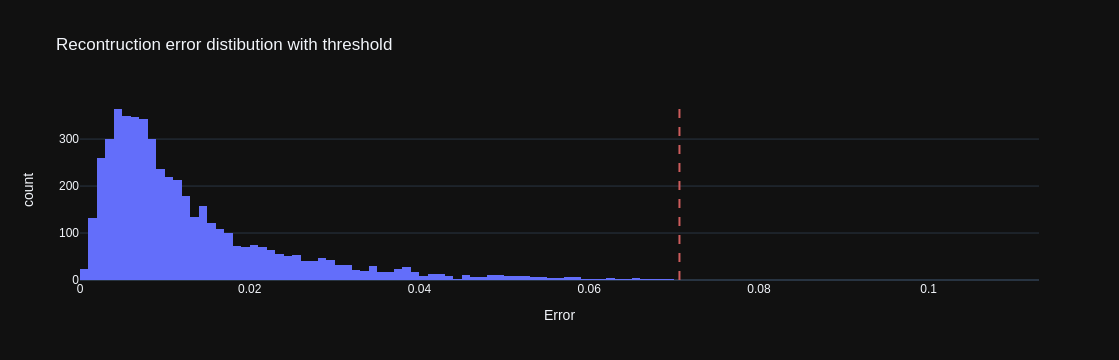

In [181]:
# plot histogram and add a vertical line at the threshold cut off point
fig = px.histogram(x=errors, height=340, width=700, labels={'x': 'Error'},
                   title='Recontruction error distibution with threshold')
fig.update_layout(shapes=[
    dict(type='line', yref='paper', y0=0, y1=1, xref='x', x0=thresh, x1=thresh,
        line=dict(color="indianred", width=2, dash="dash"))
])

We can now create a new DataFrame and add `is_anomaly` feature based on the error value.

Then we can sort this dataset by error in descending order and view the data behind the observations with highest error:

In [141]:
# take a look at a few images with highest error
errors_df = pd.DataFrame({'mse': errors, 'fpath_name': y_test})
errors_df['is_anomaly'] = 'N'
errors_df.loc[errors_df['mse'] >= thresh, 'is_anomaly'] = 'Y'
errors_df.sort_values('mse', ascending=False).head(7)

,mse,fpath_name,is_anomaly
2290,0.112240,/data/security_cam_detections_v2/Front-Parking...,Y
3616,0.100090,/data/security_cam_detections_v2/Front-Parking...,Y
541,0.097094,/data/security_cam_detections_v2/Front-Parking...,Y
2746,0.095558,/data/security_cam_detections_v2/Front-Parking...,Y
1737,0.092733,/data/security_cam_detections_v2/Front-Parking...,Y
2472,0.091582,/data/security_cam_detections_v2/Front-Parking...,Y
4372,0.089348,/data/security_cam_detections_v2/Front-Parking...,Y


The last step is to take a look at the records with the highest error and display the original image, the test-set and reconstructed versions to understand how the errors are generated.

Error: 0.1122402474284172, img idx: 2290, date: 2019-12-16, file: 08.39.24.685_1a00446f_car.jpg


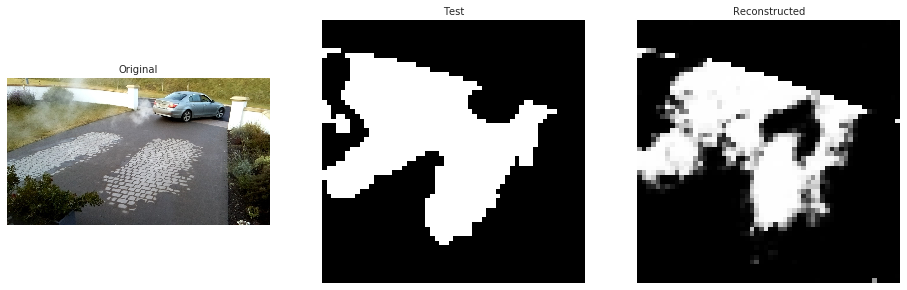

***************************
Error: 0.10009003430604935, img idx: 3616, date: 2020-01-12, file: 14.36.56.561_2ed46c60_person-person.jpg


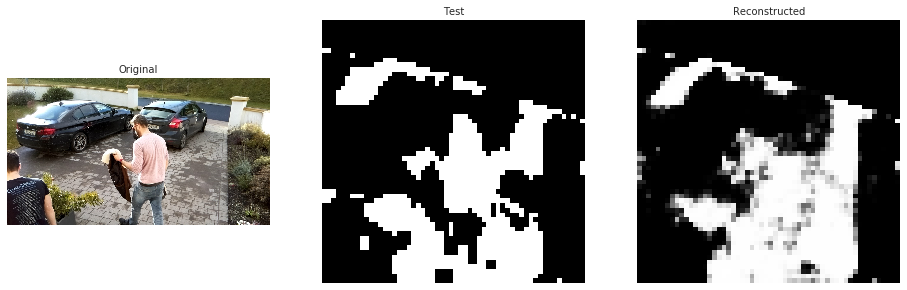

***************************
Error: 0.09709431976079941, img idx: 541, date: 2020-01-18, file: 12.36.46.604_3313648e_person.jpg


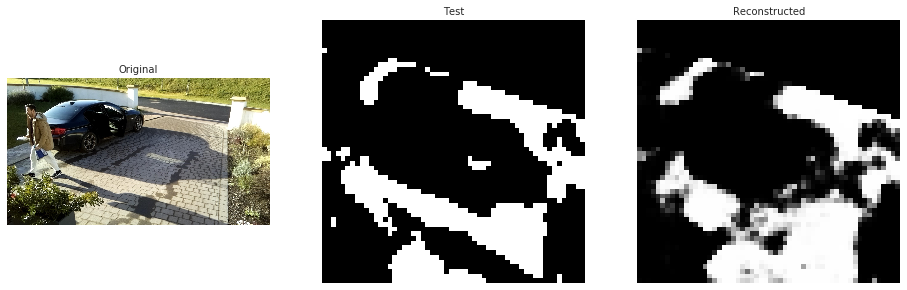

***************************
Error: 0.09555815905332565, img idx: 2746, date: 2019-12-15, file: 15.07.49.060_26caedc6_person-person-person-person-person-person-person-car.jpg


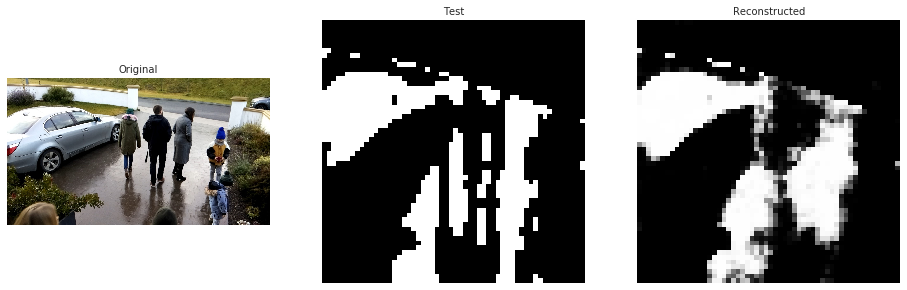

***************************
Error: 0.0927329733967781, img idx: 1737, date: 2019-09-29, file: 17.01.13.680_a34e6daa_person-person-car-car-car.jpg


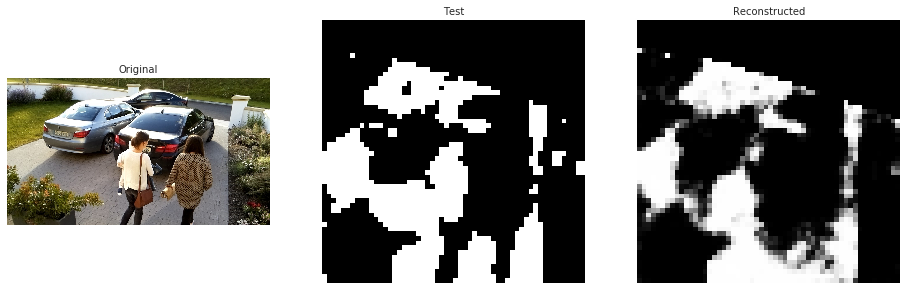

***************************


In [142]:
n_rows = 5
idxs = errors_df.nlargest(n_rows, 'mse').index
for idx in idxs:
    # extract test and reconstructed images and
    # re-normalize and set as uint8, so opencv can read it
    test_img = (X_test[idx] * 255).astype("uint8")
    reconst_img = (reconstructed_data[idx] * 255).astype("uint8")
    
    # find out original image name and load it through open-cv
    img_path = y_test[idx]
    print(f"Error: {errors[idx]}, img idx: {idx}, date: {img_path.split('/')[4]}, file: {img_path.split('/')[5]}")
    im_raw = cv2.imread(img_path)
    
    # plot pair of images
    plt.figure(figsize=(16, 5)) # specifying the overall grid size
    plt.subplot(1, 3, 1) # image 1 in the grid is 1*3
    plt.imshow(cv2.cvtColor(im_raw, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Original', fontsize=10)
    plt.subplot(1, 3, 2) # image 2 in the grid is 1*3
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Test', fontsize=10)
    plt.subplot(1, 3, 3) # image 3 in the grid is 1*3
    plt.imshow(cv2.cvtColor(reconst_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Reconstructed', fontsize=10)
    plt.axis('off')
    plt.show()
    print('***************************')

As we can see in the set of images above, the procedure does a good enough job at reconstructing test images, but - as expected - some information is lost in the process.

But what if we take a look at a few sample observations with the lowest error? Are they reconstructed better? We can reverse the procedure above and display the top 2 images with the lowest error:

Error: 7.634191570105031e-05, img idx: 591, date: 2020-02-02, file: 21.40.29.466_b527d7c5_car.jpg


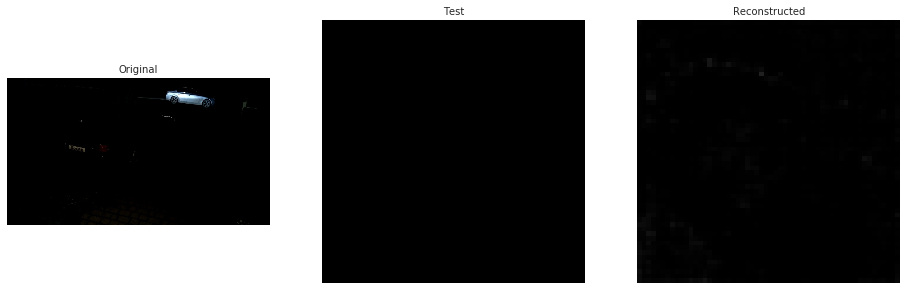

***************************
Error: 7.634191570105031e-05, img idx: 773, date: 2020-02-02, file: 19.31.42.984_0582517b_car.jpg


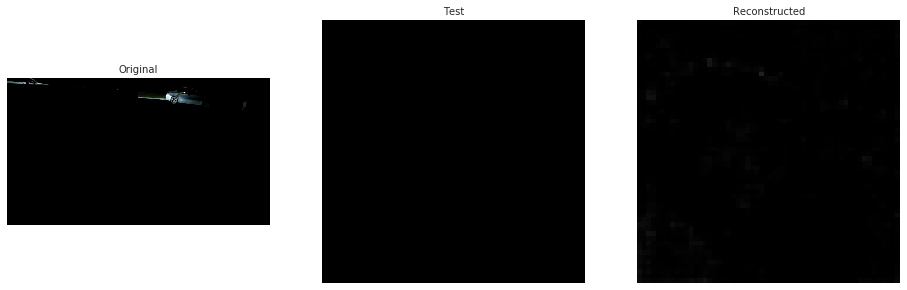

***************************


In [143]:
n_rows = 2
idxs = errors_df.nsmallest(n_rows, 'mse').index
for idx in idxs:
    # extract test and reconstructed images and
    # re-normalize and set as uint8, so opencv can read it
    test_img = (X_test[idx] * 255).astype("uint8")
    reconst_img = (reconstructed_data[idx] * 255).astype("uint8")
    
    # find out original image name and load it through open-cv
    img_path = y_test[idx]
    print(f"Error: {errors[idx]}, img idx: {idx}, date: {img_path.split('/')[4]}, file: {img_path.split('/')[5]}")
    im_raw = cv2.imread(img_path)
    
    # plot pair of images
    plt.figure(figsize=(16, 5)) # specifying the overall grid size
    plt.subplot(1, 3, 1) # image 1 in the grid is 1*3
    plt.imshow(cv2.cvtColor(im_raw, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Original', fontsize=10)
    plt.subplot(1, 3, 2) # image 2 in the grid is 1*3
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Test', fontsize=10)
    plt.subplot(1, 3, 3) # image 3 in the grid is 1*3
    plt.imshow(cv2.cvtColor(reconst_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Reconstructed', fontsize=10)
    plt.axis('off')
    plt.show()
    print('***************************')

So this is actually suprising, but it makes intuitive sense. Dark images contain a lot of pixels with a value of zero, so reconstructing those is much easier for the model and therefore the error will be much lower as well.

One idea to improve this would be to have two separate models: one for bright, and one for dark images. But the ultimate approach would be to invest in a night vision camera, which would result in a much more professional system with more capabilities. I will leave this for the future experiments.

So, what can we say about the output of the procedure?

It shows a good potential. The images classified as anomalous are different enough from the most common observations with low unusual activity and with more search for the optimal parameters, it can be optimized further.

It most likely needs some improvements in the data collection stage, and perhaps more computer vision preprocessing steps (for example image 5 in highest errors was flagged due to the dry patches of otherwise wet surface).

It would also make sense to introduce a flag in the dataset if owners are currently occupying home, as anomalies should probably be detected when owners are not at home.

Finally the training procedure needs to be carefully crafted. Instead of training the model on the whole data, a better idea would be to train on a few rolling months. This would help if an area changes over time (people change cars, plant new trees, or simply move the camera to another location).

But all these dilemmas open up a lot of opportunities for ideas and improvements.

### Test on hand-labelled data

The very last step in terms of auto-encoder analysis is to see how it behaves when we feed it with the hand-picked images.

I have annotated 14 images:
- 4 as non-anomalous
- 10 as anomalous

The process is almost the same as error calculation in the previous step (I have defined a function called `test_anomalies` for this task):
- load images from the disk
- preprocess images and reshape
- run prediction through autoencoder Keras model
- calculate mean squared errors
- establish if we found an anomaly based on a given threshold
- show images \[optionaly\]
- plot errors \[optionaly\]
- return accuracy versus expectation

In [210]:
def test_anomalies(test_dir, ae, errors, thresh, is_anomaly, show_images=True, show_err_plt=True):
    """
    Function to read images from a folder and use auto-encoder
    to reconstruct those, perform anomaly analysis and return
    accuracy of anomaly detection
    """
    
    # keep track of correct predictions
    correct_count = 0
    
    # read images
    file_list = os.listdir(test_dir)
    orig_imgs = []
    processed_imgs = []
    for img in os.listdir(test_dir):
        orig_img = cv2.imread(f'{test_dir}/{img}')
        orig_imgs.append(orig_img)
        processed_imgs.append(process_frame(orig_img, (WIDTH, HEIGHT), True, True, True, True, POLY_VALUES))
    orig_imgs = np.array(orig_imgs)
    processed_imgs = np.array(processed_imgs)

    # reshape processed images to Keras CNN expectated format (with channel dimension)
    processed_imgs = np.squeeze(processed_imgs)
    processed_imgs = np.expand_dims(processed_imgs, axis=-1)
    processed_imgs = processed_imgs.astype("float32") / 255.0

    # use autoencoder to reconstruct images
    reconstructed_data = ae.predict(processed_imgs)

    # calculate errors between processed and reconstructed images
    # calculate errors for test-set
    test_errors = []
    for (image, recon) in zip(processed_imgs, reconstructed_data):
        # compute the mean squared error between the ground-truth image
        # and the reconstructed image, then add it to our list of errors
        mse = np.mean((image - recon) ** 2)
        test_errors.append(mse)
    test_errors = np.array(test_errors)

    for idx, im in enumerate(processed_imgs):
        # extract test and reconstructed images and
        # re-normalize and set as uint8, so opencv can read it
        test_img = (processed_imgs[idx] * 255).astype("uint8")
        reconst_img = (reconstructed_data[idx] * 255).astype("uint8")

        # figure out if the image is an anomaly
        if test_errors[idx] >= thresh:
            found_anomaly = True
        else:
            found_anomaly = False        
        if (is_anomaly and found_anomaly) or (not is_anomaly and not found_anomaly):
            correct_count += 1
            
        if show_images:
            print(f"Error: {test_errors[idx]}, img idx: {idx}, " + ('ANOMALY!' if found_anomaly else 'not anomaly'))
            # plot pair of images
            plt.figure(figsize=(16, 5)) # specifying the overall grid size
            plt.subplot(1, 3, 1) # image 1 in the grid is 1*3
            plt.imshow(cv2.cvtColor( orig_imgs[idx], cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f'Original', fontsize=10)
            plt.subplot(1, 3, 2) # image 2 in the grid is 1*3
            plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f'Test', fontsize=10)
            plt.subplot(1, 3, 3) # image 3 in the grid is 1*3
            plt.imshow(cv2.cvtColor(reconst_img, cv2.COLOR_BGR2RGB))
            plt.title(f'Reconstructed', fontsize=10)
            plt.axis('off')
            plt.show()
            print('***************************')

    
    if show_err_plt:
        # plot histogram and add a vertical line at the threshold cut off point
        fig = px.histogram(x=errors, height=340, width=700, labels={'x': 'Error'},
                           title='Recontruction errors for ' + ('' if is_anomaly else 'non-')
                           + 'anomalous observations')
        shapes = [
            dict(type='line', yref='paper', y0=0, y1=1, xref='x', x0=thresh, x1=thresh,
                line=dict(color="indianred", width=2, dash="dash"))
        ]
        for err in test_errors:
            line_color = 'red' if is_anomaly else '#5fbaa7'
            shapes.append(dict(type='line', yref='paper', y0=0, y1=1, xref='x', x0=err, x1=err,
                line=dict(color=line_color, width=2, dash="dashdot")))

        fig.update_layout(shapes=shapes)
        fig.show()

    # return accuracy and count of files
    return correct_count / len(file_list), len(file_list)

First test non-anomalous images

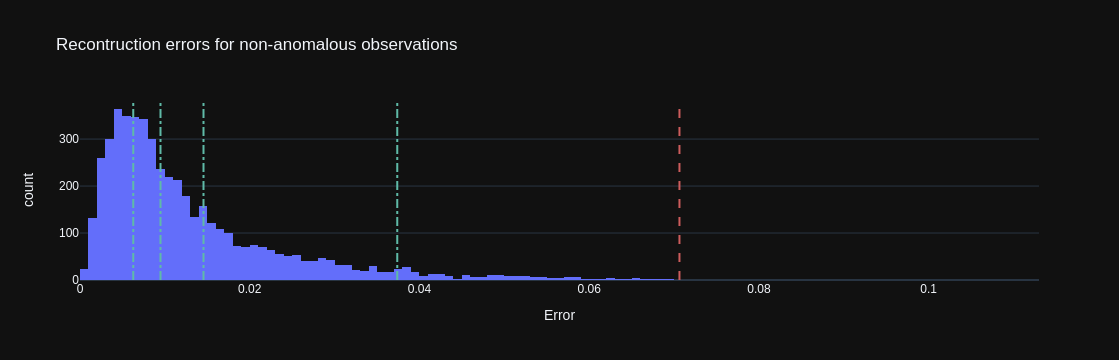

Accuracy scored: 100.0% (out of 4 samples)


In [216]:
test_dir = '../Datasets/anomalies_labelled/no'
acc, file_count = test_anomalies(test_dir, ae, errors, thresh, is_anomaly=False, show_images=False, show_err_plt=True)
print(f'Accuracy scored: {acc * 100}% (out of {file_count} samples)')

Now test anomalous images

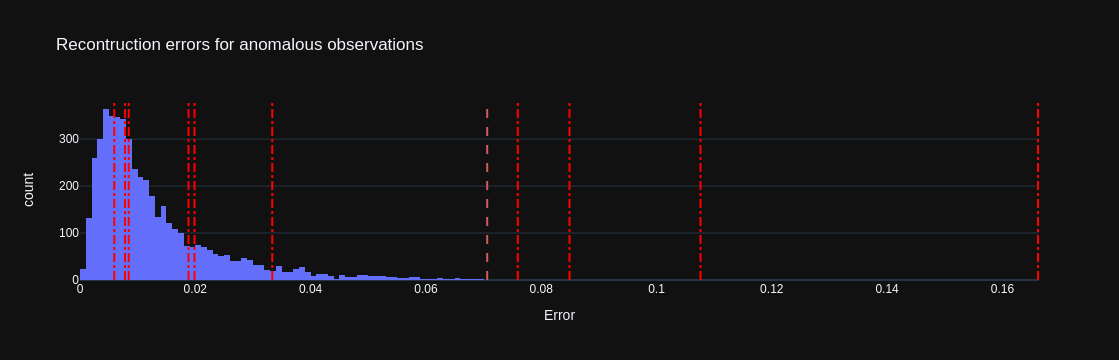

Accuracy scored: 40.0% (out of 10 samples)


In [215]:
test_dir = '../Datasets/anomalies_labelled/yes'
acc, file_count = test_anomalies(test_dir, ae, errors, thresh, is_anomaly=True, show_images=False, show_err_plt=True)
print(f'Accuracy scored: {acc * 100}% (out of {file_count} samples)')

#### Results:

- plots show clearly that all non-anomalous observations reside on the left side of the threshold, but anomalous observations reside on both sides (with 4 observations out of 10 being on the right hand side)
- non-anomalous images: accuracy 100%
- anomalous images: accuracy 40%, where model made some mistakes on the nightly images, and it's most likely due to the camera used in the experiment

### Conclusion

The accuracy scores above are rather good for the given task.

We should always expect some False Positive anomalous observations to be detected, but this and the plots above prove that the method actually works and can be very useful to detect anomalies on the fly from the video streams.

The next improvement here would be to spend more time on tuning model parameters (see Appendix below how this can be optimized) and to test a variation of auto-encoder called the Variational Auto-Encoder, which normalizes the latent space from a very sparse to more continuous having Standard Normal shape using Kullback–Leibler divergence in the loss function. (TODO: provide resource)

### Appendix / Training loop

To speed up model and data processing techniques selection - the code sample below creates all possible datasets and models from a given array of options.

Datasets and models are saved them to disk, so they can be quickly accessed and loaded for testing or for making predictions.

There are so many permutations of potential options to select here that it can get overwheling very quickly and it could take infinity to test all possible options. It is much better to create a loop from the parameter space and leave it to run overnight. Then we can pick it up on the next day and evalluate results.

Python has a very useful tool, which accepts a list of lists and creates a carthesian product from them. It can be found under `itertools.product` function.

The following code has run for around 12 hours on Intel i5 with 32GM RAM, fast NVME m2 SSD and 1080Ti GTX GPU to train 72 versions of  auto-encoders defined in the specification (`real_params` variable below).

Every iteration in the loop sets the `is_gray` parameter to True, as adding additional dimension will result is slow porformance and there is no benefit in using color images for this exercise.

In [108]:
# test combination of parameters automatically in a one big loop
# (caution: this loop can easily take over 10 hours on a powerful system)
import itertools

LOAD_DATASETS_FROM_DISK = True
histories = {}
# parameter elements: ((number of samples), (resolutions), (blur), (thresh), (polygon mask))
real_params = ((25000, 50000), (28, 56, 112), (False, True), (False, True), (False, True))
# test_params = ((500, 1000), (28, 56), (False, True), (False, True), (False, True))

for n_samples, dim, is_blur, is_thresh, is_poly in itertools.product(*real_params):
    
    model_name = f'nsamples{n_samples}_res{dim}_blur{is_blur}_thresh{is_thresh}_poly{is_poly}'
    print(f'Running model: *{model_name}*')
    print(f'Time is: {str(dt.now())}')
    
    dest_file_data = f'../Datasets/raw_images_processed/img__{model_name}.npy'
    dest_file_filenames = f'../Datasets/raw_images_processed/filepaths__{model_name}.npy'

    # how many rows to sample from dataframe
    NUM_ROWS = n_samples

    # resize images from 1080p to these dimensions
    WIDTH, HEIGHT = dim, dim
    
    # check if datasets creation is required
    if LOAD_DATASETS_FROM_DISK:
        im_data, im_filepaths = np.load(dest_file_data), np.load(dest_file_filenames)
    else:
        # sample records from the dataframe
        samples = df.sample(NUM_ROWS, random_state=CONFIG['RANDOM_STATE'])  # provide random_state for reproducibility
        
        # pre-process images into a numpy array
        POLY_VALUES = np.array([[0, 0], [1, 0], [1, 0.37], [0.5, 0.21], [0.25, 0.13], [0, 0.09]])
        im_data, im_filepaths = process_img_batch(samples, WIDTH, HEIGHT, is_blur, is_thresh, is_poly, POLY_VALUES)
    
        # save numpy arrays in the Datasets (efficient binary format)
        np.save(dest_file_data, im_data)
        np.save(dest_file_filenames, im_filepaths)

    print(f'Training Data sample shape: {im_data.shape}')
    print(f'Size in RAM: {round((im_data.size * im_data.itemsize) / 1024 / 1024, 2)} MB')
    print(f"{round(NUM_ROWS / df.shape[0], 3) * 100}% of overall dataset ({NUM_ROWS} out of {df.shape[0]} data points)")

    # add a channel dimension to every image in the dataset, then scale
    # the pixel intensities to the range [0, 1]
    im_data = np.squeeze(im_data)
    im_data = np.expand_dims(im_data, axis=-1)
    im_data = im_data.astype("float32") / 255.0
    print(f'Data reshaped shape: {im_data.shape}')

    # construct the training and testing split,
    # use random_state for reproducability, set to None
    # in production
    X_train, X_test, y_train, y_test = train_test_split(im_data, im_filepaths,test_size=0.2,
                                                        random_state=CONFIG['RANDOM_STATE'])
    print(f'Train shape: {X_train.shape}, test shape: {X_test.shape}')
    
    # build convolutional auto-encoder, override default epoch size,
    # this will be used to set the optimizer's learning rate decay
    EPOCHS = 40  # this should be a safe bet even for larger datasets
    ae, enc, dec = build_ae(WIDTH, HEIGHT, epochs=EPOCHS)
    
    # train the convolutional autoencoder,
    # note that the labels are actually the same
    # as the training data
    BS = 32
    H = ae.fit(X_train, X_train, validation_data=(X_test, X_test),
                        epochs=EPOCHS, batch_size=BS, verbose=0)  # verbose to 0 to silence the noisy Keras output
    
    # save history data for future analysis and testing
    histories[model_name] = {'loss': H.history["loss"], 'val_loss': H.history["val_loss"], 'ts': str(dt.now())}
    
    # save weights for future analysis and testing
    filename = f'../Datasets/weights/{model_name}.h5'
    ae.save(filename)
    print("Model saved to disk")
    
    # reconstruct data
    reconstructed_data = ae.predict(X_test)
    
    # calculate errors for test-set
    errors = []
    for (image, recon) in zip(X_test, reconstructed_data):
        # compute the mean squared error between the ground-truth image
        # and the reconstructed image, then add it to our list of errors
        mse = np.mean((image - recon) ** 2)
        errors.append(mse)
    errors = np.array(errors)
    
    # compute the q-th quantile of the errors which serves as our
    # threshold to identify anomalies -- any data point that our model
    # reconstructed with > threshold error will be marked as an outlier
    thresh = np.quantile(errors, 0.997)
    idxs = np.where(np.array(errors) >= thresh)[0]
    print(f"Mse threshold: {thresh}")
    print(f"Outliers found: {len(idxs)}")
    
    # take a look at a few images with highest error
    errors_df = pd.DataFrame({'mse': errors, 'y_test': y_test})
    errors_df['is_anomaly'] = 'N'
    errors_df.loc[errors_df['mse'] >= thresh, 'is_anomaly'] = 'Y'
    errors_df = errors_df.sort_values('mse', ascending=False)
    csv_filename = f'../Datasets/anomaly_results/{model_name}.csv'
    errors_df.head(50).to_csv(csv_filename, index=False)
    print('*******************************')

now = str(dt.now())
filename = f'../Datasets/histories/history_run_{now}.pickle'
outfile = open(filename, 'wb')
pickle.dump(histories, outfile)
outfile.close()
print(f'Done. Time is {now}')

Running model: *nsamples25000_res28_blurFalse_threshFalse_polyFalse*
Time is: 2020-06-08 22:27:13.336763
Training Data sample shape: (25000, 28, 28)
Size in RAM: 18.69 MB
3.9% of overall dataset (25000 out of 643471 data points)
Data reshaped shape: (25000, 28, 28, 1)
Train shape: (20000, 28, 28, 1), test shape: (5000, 28, 28, 1)
Model saved to disk
Mse threshold: 0.027814013442024565
Outliers found: 15
*******************************
Running model: *nsamples25000_res28_blurFalse_threshFalse_polyTrue*
Time is: 2020-06-08 22:31:20.088679
Training Data sample shape: (25000, 28, 28)
Size in RAM: 18.69 MB
3.9% of overall dataset (25000 out of 643471 data points)
Data reshaped shape: (25000, 28, 28, 1)
Train shape: (20000, 28, 28, 1), test shape: (5000, 28, 28, 1)
Model saved to disk
Mse threshold: 0.02523102268390352
Outliers found: 15
*******************************
Running model: *nsamples25000_res28_blurFalse_threshTrue_polyFalse*
Time is: 2020-06-08 22:35:33.821717
Training Data sample